In [4]:
#1.DATA PREPROCESSING

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ===============================
# Load train and test datasets
# ===============================
train_df = pd.read_csv("D:/guviprojects/Click/train_data (2).csv")
test_df = pd.read_csv("D:/guviprojects/Click/test_data (2).csv")

# ===============================
# 1. Handle Missing Values
# ===============================
def handle_missing_values(df):
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
    return df

train_df = handle_missing_values(train_df)
test_df = handle_missing_values(test_df)

# ===============================
# 2. Label Encoding on Categorical Columns
# ===============================
categorical_cols = [
    'country',
    'page1_main_category',
    'colour',
    'location',
    'model_photography',
    'price_2'
]

# Fit LabelEncoders on combined data to avoid unseen label issues
combined_df = pd.concat([train_df[categorical_cols], test_df[categorical_cols]])

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(combined_df[col])
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

# ===============================
# 3. Scaling Numeric Columns
# ===============================
numerical_cols = ['price', 'order', 'day', 'month']
scaler = StandardScaler()

train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

# ===============================
# Summary Output
# ===============================
print("Data Preprocessing Completed")
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Sample Preprocessed Train Data:")
print(train_df.head())


Data Preprocessing Completed
Train shape: (132379, 14)
Test shape: (33095, 14)
Sample Preprocessed Train Data:
   year     month       day     order  country  session_id  \
0  2008  0.314174  0.848597  0.831323       28       15648   
1  2008 -0.438805  0.508811 -0.283182       28       10018   
2  2008  1.067153  0.055762 -0.580383       28       19388   
3  2008 -0.438805 -1.416646 -0.580383       28        7181   
4  2008  0.314174 -0.623811  0.459822       28       13493   

   page1_main_category page2_clothing_model  colour  location  \
0                    2                  C20      12         0   
1                    1                  B26      12         2   
2                    2                  C13       8         4   
3                    1                  B11       1         3   
4                    1                  B31       8         4   

   model_photography     price  price_2  page  
0                  1  0.335888        0     2  
1                  0  1.05362

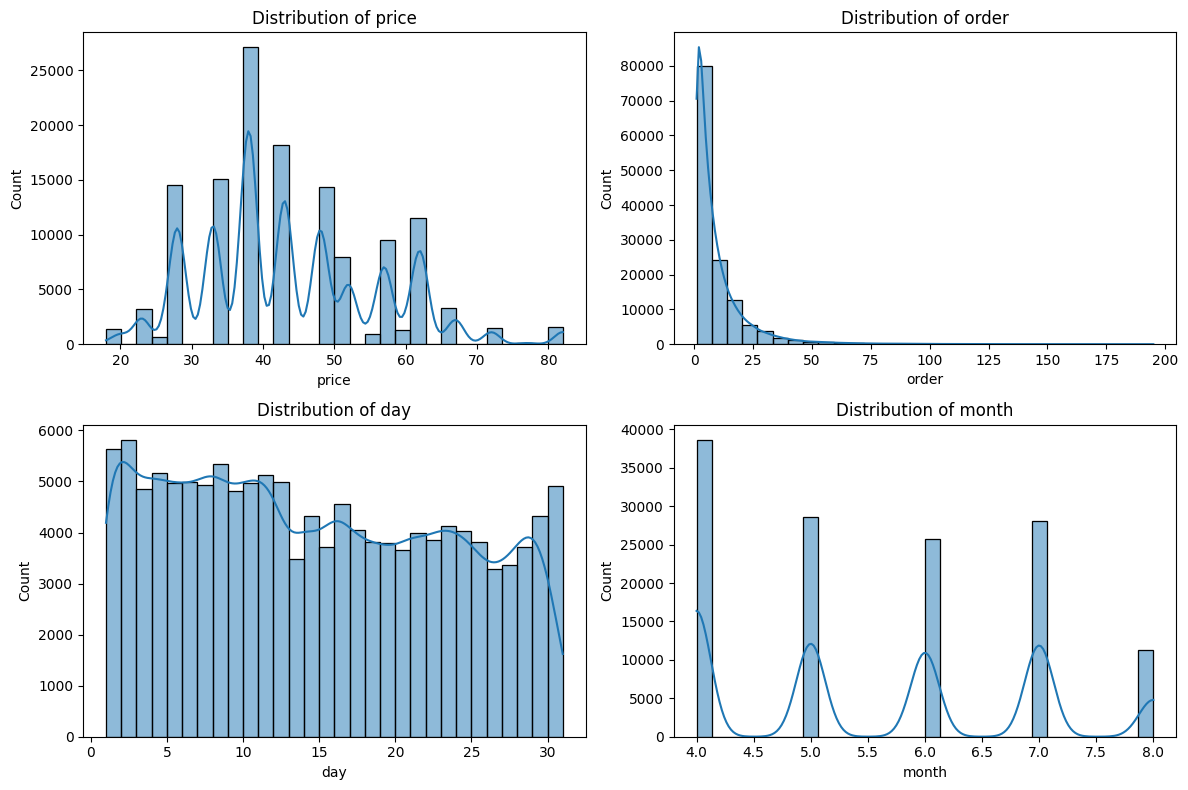

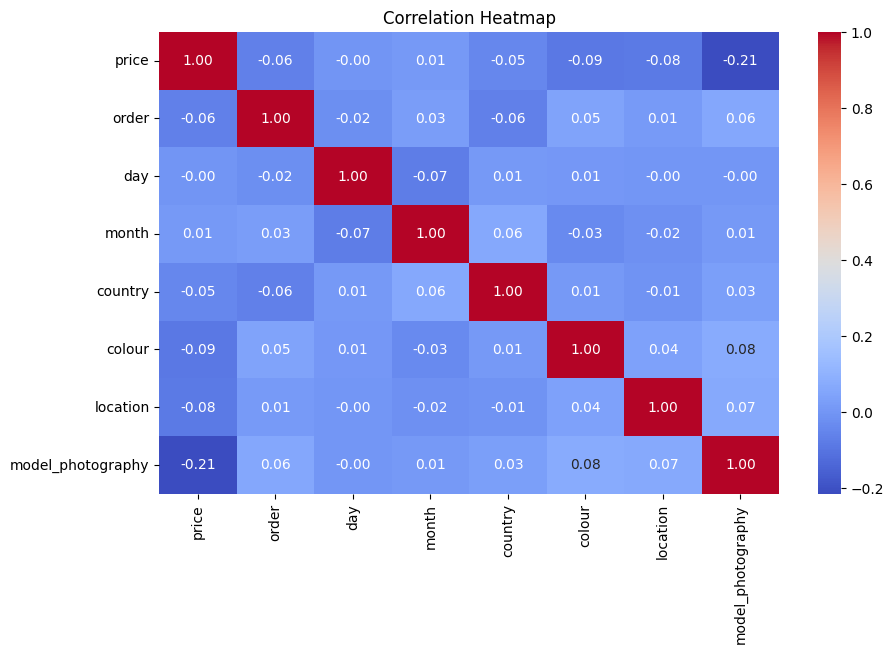

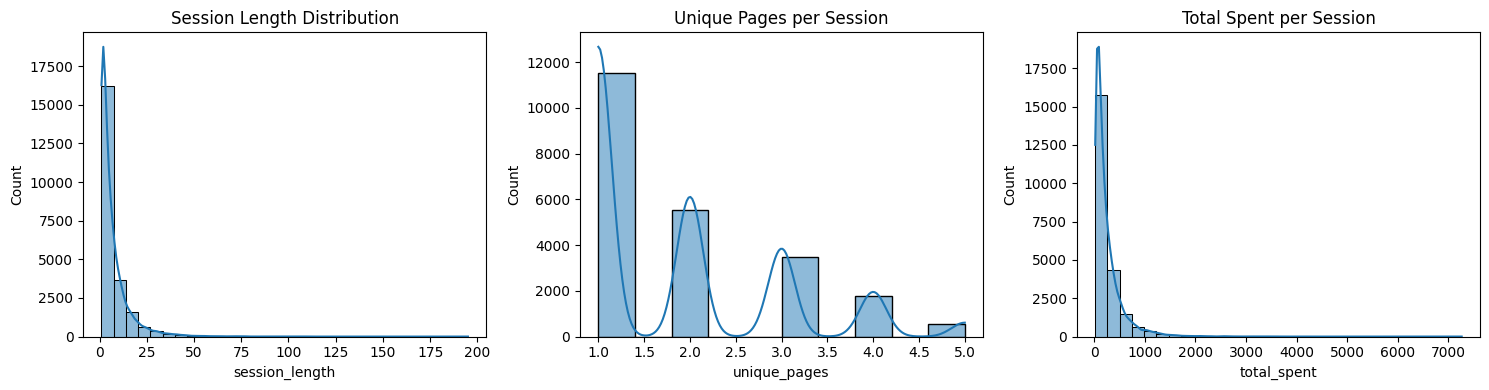

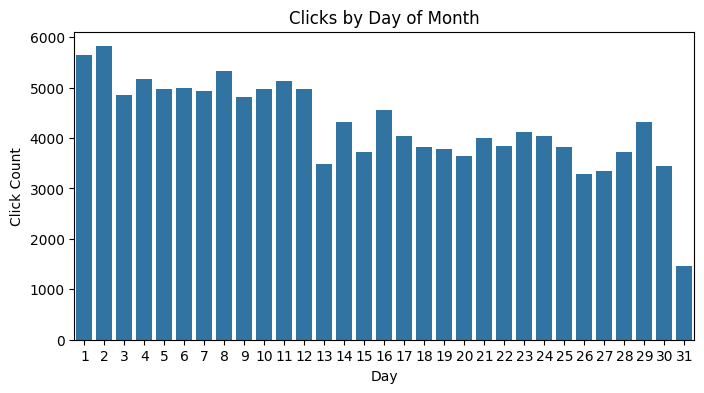

In [8]:
#Step 2: Exploratory Data Analysis (EDA)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Load preprocessed train data
train_df = pd.read_csv("D:/guviprojects/CLICKSTREAM/train_data (2).csv")

# -------------------------------------
# 1. Distribution Visualizations
# -------------------------------------
numerical_cols = ['price', 'order', 'day', 'month']

plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# -------------------------------------
# 2. Correlation Heatmap
# -------------------------------------
corr = train_df[['price', 'order', 'day', 'month', 'country', 'colour', 'location', 'model_photography']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# -------------------------------------
# 3. Session-Level Analysis
# -------------------------------------
session_df = train_df.groupby('session_id').agg({
    'order': 'max',                  # session length (clicks)
    'page': 'nunique',              # unique pages visited
    'price': 'sum'                  # total money spent
}).reset_index()

session_df.columns = ['session_id', 'session_length', 'unique_pages', 'total_spent']

# -------------------------------------
# 4. Visualize Session Metrics
# -------------------------------------
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.histplot(session_df['session_length'], bins=30, kde=True)
plt.title('Session Length Distribution')

plt.subplot(1, 3, 2)
sns.histplot(session_df['unique_pages'], bins=10, kde=True)
plt.title('Unique Pages per Session')

plt.subplot(1, 3, 3)
sns.histplot(session_df['total_spent'], bins=30, kde=True)
plt.title('Total Spent per Session')

plt.tight_layout()
plt.show()

# -------------------------------------
# 5. Time-based Analysis: Page views per day
# -------------------------------------
plt.figure(figsize=(8, 4))
sns.countplot(x='day', data=train_df)
plt.title('Clicks by Day of Month')
plt.xlabel('Day')
plt.ylabel('Click Count')
plt.show()


In [26]:
#Step 3: Feature Engineering Code


import pandas as pd

# Load the preprocessed training data
train_df = pd.read_csv("D:/guviprojects/CLICKSTREAM/train_data (2).csv")

# -------------------------------
# 1. Session-Level Metrics
# -------------------------------
session_metrics = train_df.groupby('session_id').agg(
    session_length=('order', 'max'),               # depth of click
    num_clicks=('order', 'count'),                 # number of interactions
    category_diversity=('page1_main_category', 'nunique'),  # how many product categories seen
    total_spent=('price', 'sum')                   # total price of viewed products
).reset_index()

# -------------------------------
# 2. Clickstream Patterns
# -------------------------------
# Store full click sequence of product categories per session
click_paths = train_df.groupby('session_id')['page1_main_category'].apply(list).reset_index()
click_paths.rename(columns={'page1_main_category': 'click_sequence'}, inplace=True)

# -------------------------------
# 3. Behavioral Metrics
# -------------------------------
# Bounce Rate: session with only one click
session_metrics['bounce'] = session_metrics['num_clicks'].apply(lambda x: 1 if x == 1 else 0)

# Exit Page: last category visited in each session
last_clicks = train_df.sort_values(['session_id', 'order']).groupby('session_id').tail(1)
last_clicks = last_clicks[['session_id', 'page1_main_category']]
last_clicks.rename(columns={'page1_main_category': 'exit_page'}, inplace=True)

# -------------------------------
# 4. Merge All Session Features
# -------------------------------
session_features = session_metrics.merge(click_paths, on='session_id')
session_features = session_features.merge(last_clicks, on='session_id')

# -------------------------------
# 5. Output and Save
# -------------------------------
print(" Feature Engineering Completed")
print("Session-Level Feature Sample:")
print(session_features.head())

session_features.to_csv("D:/guviprojects/Click/session_features.csv", index=False)



 Feature Engineering Completed
Session-Level Feature Sample:
   session_id  session_length  num_clicks  category_diversity  total_spent  \
0           1               9           8                   4          351   
1           2              10           9                   3          443   
2           3               5           3                   2          134   
3           4               4           4                   2          181   
4           5               1           1                   1           57   

   bounce               click_sequence  exit_page  
0       0     [2, 2, 4, 4, 1, 3, 2, 3]          4  
1       0  [1, 4, 1, 2, 2, 2, 4, 4, 2]          4  
2       0                    [3, 3, 2]          3  
3       0                 [1, 3, 1, 3]          3  
4       1                          [3]          3  


In [58]:
#Step: Create converted Column
import pandas as pd

# Load engineered session-level dataset
session_df = pd.read_csv("D:/guviprojects/CLICKSTREAM/session_features.csv")

# Create 'converted' label based on bounce and exit_page logic
session_df['converted'] = session_df.apply(
    lambda row: 1 if (row['bounce'] == 0 and row['exit_page'] in [2, 3, 4]) else 0,
    axis=1
)


# Optional: Save updated session features
session_df.to_csv("D:/guviprojects/Click/session_features.csv", index=False)

# View distribution
print("Class distribution:")
print(session_df['converted'].value_counts())


Class distribution:
converted
1    12871
0    10039
Name: count, dtype: int64


In [60]:
# Step 4: Balancing Techniques for Classification

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# -------------------------------------
# Load session-level data
# -------------------------------------
session_df = pd.read_csv("D:/guviprojects/Click/session_features.csv")

# -------------------------------------
# Features and target
# -------------------------------------
X = session_df.drop(columns=['session_id', 'converted', 'click_sequence'])
y = session_df['converted']

# -------------------------------------
# 1. Identify Imbalance
# -------------------------------------
print("Original Class Distribution:\n", y.value_counts())

# -------------------------------------
# 2. Train-Test Split
# -------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------------------------
# 3. SMOTE (Oversampling)
# -------------------------------------
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE (Oversampling):")
print(y_train_smote.value_counts())

# -------------------------------------
# 4. Class Weight Adjustment (Optional)
# -------------------------------------
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("\nClass Weights for Model Training:", class_weight_dict)


Original Class Distribution:
 converted
1    12871
0    10039
Name: count, dtype: int64

After SMOTE (Oversampling):
converted
1    10297
0    10297
Name: count, dtype: int64

Class Weights for Model Training: {np.int64(0): np.float64(1.1410783215041713), np.int64(1): np.float64(0.8899679518306303)}


In [57]:
print(y_train_smote.value_counts())


converted
0    15089
1    15089
Name: count, dtype: int64


In [65]:
# Step 5: Model Building (Classification) – Full Pipeline Code

import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
import joblib

# -------------------------------------
# Load session-level data
# -------------------------------------
session_df = pd.read_csv("D:/guviprojects/Click/session_features.csv")
X = session_df.drop(columns=['session_id', 'converted', 'click_sequence', 'exit_page', 'bounce'])

y = session_df['converted']
features = X.columns.tolist()

# -------------------------------------
# Train-Test Split
# -------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------------------------
# SMOTE Oversampling
# -------------------------------------
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", Counter(y_train_resampled))

# -------------------------------------
# Model 1: Logistic Regression
# -------------------------------------
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])
logreg_pipeline.fit(X_train_resampled, y_train_resampled)
y_pred_log = logreg_pipeline.predict(X_test)
f1_log = f1_score(y_test, y_pred_log)

print("\n[Logistic Regression Results]")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# -------------------------------------
# Model 2: Random Forest
# -------------------------------------
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])
rf_pipeline.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_pipeline.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf)

print("\n[Random Forest Results]")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Save RandomForest model and features
joblib.dump(rf_pipeline, "models/RandomForest_model.pkl")
joblib.dump(features, "models/features_used.pkl")

# -------------------------------------
# Model 3: XGBoost Classifier
# -------------------------------------
scale_weight = round(y_train_resampled.value_counts()[0] / y_train_resampled.value_counts()[1], 2)
xgb_model = XGBClassifier(
    scale_pos_weight=scale_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("\n[XGBoost Results]")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# -------------------------------------
# Best Model Summary
# -------------------------------------
print("\n[F1-Score Summary]")
print(f"Logistic Regression F1: {f1_log:.4f}")
print(f"Random Forest F1:       {f1_rf:.4f}")
print(f"XGBoost F1:             {f1_xgb:.4f}")


Class distribution after SMOTE: Counter({1: 10297, 0: 10297})

[Logistic Regression Results]
[[1496  512]
 [ 765 1809]]
              precision    recall  f1-score   support

           0       0.66      0.75      0.70      2008
           1       0.78      0.70      0.74      2574

    accuracy                           0.72      4582
   macro avg       0.72      0.72      0.72      4582
weighted avg       0.73      0.72      0.72      4582


[Random Forest Results]
[[1375  633]
 [ 436 2138]]
              precision    recall  f1-score   support

           0       0.76      0.68      0.72      2008
           1       0.77      0.83      0.80      2574

    accuracy                           0.77      4582
   macro avg       0.77      0.76      0.76      4582
weighted avg       0.77      0.77      0.76      4582


[XGBoost Results]
[[1256  752]
 [ 206 2368]]
              precision    recall  f1-score   support

           0       0.86      0.63      0.72      2008
           1       

In [67]:
#Regression Pipeline Code:


import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --------------------------
# Load session-level data
# --------------------------
df = pd.read_csv("D:/guviprojects/Click/session_features.csv")

# --------------------------
# Set regression target and features (remove leakage)
# --------------------------
X = df.drop(columns=['session_id', 'converted', 'click_sequence', 'total_spent', 'exit_page', 'bounce'])
y = df['total_spent']
features = X.columns.tolist()

# --------------------------
# Train-test split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------
# Define regression models
# --------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# --------------------------
# Evaluate each model in pipeline
# --------------------------
best_model = None
best_r2 = -float('inf')
best_model_name = None

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5

    print(f"\n{name}")
    print(f"R2 Score:  {r2:.3f}")
    print(f"MAE:       {mae:.3f}")
    print(f"MSE:       {mse:.3f}")
    print(f"RMSE:      {rmse:.3f}")

    if r2 > best_r2:
        best_r2 = r2
        best_model = pipeline
        best_model_name = name

# --------------------------
# Save the best regression model and features
# --------------------------
joblib.dump(best_model, "models/Ridge_model.pkl")
 
joblib.dump(features, "models/features_used.pkl")

print(f"\n Best Model: {best_model_name} with R2 Score: {best_r2:.3f}")
print("Model and features saved successfully.")



Linear Regression
R2 Score:  0.984
MAE:       27.112
MSE:       1732.898
RMSE:      41.628

Ridge
R2 Score:  0.984
MAE:       27.108
MSE:       1732.549
RMSE:      41.624

Lasso
R2 Score:  0.984
MAE:       27.106
MSE:       1732.585
RMSE:      41.624

Gradient Boosting
R2 Score:  0.983
MAE:       27.004
MSE:       1829.638
RMSE:      42.774

 Best Model: Ridge with R2 Score: 0.984
Model and features saved successfully.


In [68]:
# 5.3 Updated Clustering Pipeline Code

import pandas as pd
import joblib
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

# --------------------------
# Load session-level data
# --------------------------
df = pd.read_csv("D:/guviprojects/Click/session_features.csv")

# --------------------------
# Prepare features (remove non-numeric / target / identifiers)
# --------------------------
clustering_df = df.drop(columns=['session_id', 'converted', 'click_sequence', 'total_spent', 'exit_page', 'bounce'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_df)

# --------------------------
# KMeans Clustering
# --------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

print("\nKMeans Clustering")
print("Silhouette Score:", silhouette_score(scaled_data, kmeans_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(scaled_data, kmeans_labels))

# Save KMeans model and scaler
joblib.dump(kmeans, "models/KMeans_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")

# --------------------------
# DBSCAN Clustering (safe check)
# --------------------------
dbscan = DBSCAN(eps=1.5, min_samples=5)
db_labels = dbscan.fit_predict(scaled_data)

if len(set(db_labels)) > 1 and -1 not in set(db_labels):
    print("\nDBSCAN Clustering")
    print("Silhouette Score:", silhouette_score(scaled_data, db_labels))
    print("Davies-Bouldin Index:", davies_bouldin_score(scaled_data, db_labels))
else:
    print("\nDBSCAN Clustering resulted in mostly noise or 1 cluster – skipped evaluation")

# --------------------------
# Hierarchical Clustering
# --------------------------
agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels = agglo.fit_predict(scaled_data)

print("\nHierarchical Clustering")
print("Silhouette Score:", silhouette_score(scaled_data, agglo_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(scaled_data, agglo_labels))



KMeans Clustering
Silhouette Score: 0.5532209917307483
Davies-Bouldin Index: 0.7019903633825381

DBSCAN Clustering resulted in mostly noise or 1 cluster – skipped evaluation

Hierarchical Clustering
Silhouette Score: 0.5426495660449807
Davies-Bouldin Index: 0.7207246661550141


In [69]:
# Step 6: Model Evaluation 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    mean_absolute_error, mean_squared_error, r2_score,
    silhouette_score, davies_bouldin_score
)
from collections import Counter

# ----------------------------
# 1. Classification Evaluation
# ----------------------------
def evaluate_classification(y_true, y_pred, y_proba=None, title="Classification Evaluation"):
    print(f"\n{title}")
    print("-" * len(title))
    print(f"Class Distribution: {Counter(y_true)}")
    print(f"Accuracy:   {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision:  {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:     {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score:   {f1_score(y_true, y_pred):.4f}")

    if y_proba is not None:
        print(f"ROC-AUC:    {roc_auc_score(y_true, y_proba):.4f}")
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label="ROC Curve")
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ----------------------------
# 2. Regression Evaluation
# ----------------------------
def evaluate_regression(y_true, y_pred, title="Regression Evaluation"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{title}")
    print("-" * len(title))
    print(f"MAE:   {mae:.2f}")
    print(f"MSE:   {mse:.2f}")
    print(f"RMSE:  {rmse:.2f}")
    print(f"R²:    {r2:.4f}")

    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=1)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ----------------------------
# 3. Clustering Evaluation
# ----------------------------
def evaluate_clustering(X, labels, title="Clustering Evaluation"):
    print(f"\n{title}")
    print("-" * len(title))
    unique_labels = np.unique(labels)
    
    if len(unique_labels) < 2:
        print("Clustering resulted in only one cluster or mostly noise. Evaluation skipped.")
        return
    
    sil_score = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    print(f"Silhouette Score:       {sil_score:.4f}")
    print(f"Davies-Bouldin Index:   {db_index:.4f}")


In [70]:
!pip install imbalanced-learn


You should consider upgrading via the 'D:\guviprojects\Click\env\Scripts\python.exe -m pip install --upgrade pip' command.



Classification Evaluation:
Accuracy:   1.0000
Precision:  1.0000
Recall:     1.0000
F1-Score:   1.0000
ROC-AUC:    1.0000


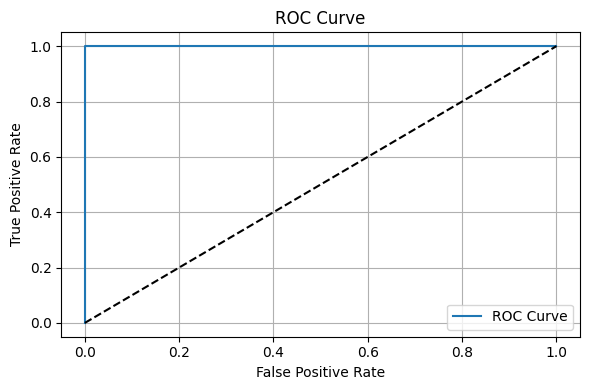


Regression Evaluation:
MAE:   24.14
MSE:   1539.36
RMSE:  39.23
R²:    0.9856


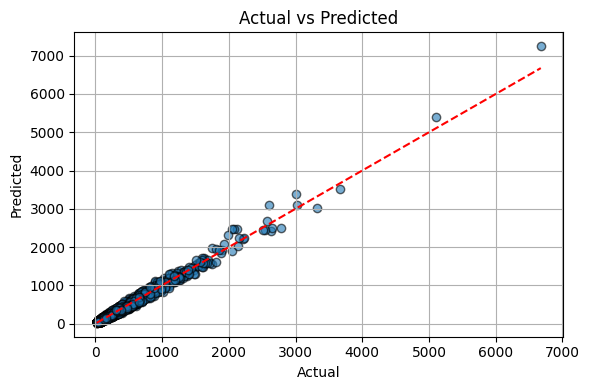


Clustering Evaluation:
Silhouette Score:       0.4278
Davies-Bouldin Index:   0.9648

All models have been trained, evaluated, and saved successfully.


In [71]:
# Step 6: Model Evaluation + Model Training and Saving

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    mean_absolute_error, mean_squared_error, r2_score,
    silhouette_score, davies_bouldin_score
)

# ----------------------------
# Load and preprocess data
# ----------------------------
file_path = "d:/guviprojects/Click/session_features.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist. Please verify the path.")

df = pd.read_csv(file_path)
features = ['session_length', 'num_clicks', 'category_diversity', 'bounce', 'exit_page']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------------
# 1. Classification Model (with SMOTE)
# ----------------------------
y_class = df['converted']
sm = SMOTE(random_state=42)
X_class_resampled, y_class_resampled = sm.fit_resample(X_scaled, y_class)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class_resampled, y_class_resampled, test_size=0.2, random_state=42)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_c, y_train_c)
y_pred_c = classifier.predict(X_test_c)
y_proba_c = classifier.predict_proba(X_test_c)[:, 1]

# ----------------------------
# 2. Regression Model
# ----------------------------
y_reg = df['total_spent']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_r, y_train_r)
y_pred_r = regressor.predict(X_test_r)

# ----------------------------
# 3. Clustering Model
# ----------------------------
cluster_model = KMeans(n_clusters=3, random_state=42)
cluster_model.fit(X_scaled)
clusters = cluster_model.predict(X_scaled)

# ----------------------------
# Evaluation Functions
# ----------------------------
def evaluate_classification(y_true, y_pred, y_proba=None, title="Classification Evaluation"):
    print(f"\n{title}:")
    print(f"Accuracy:   {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision:  {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:     {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score:   {f1_score(y_true, y_pred):.4f}")
    if y_proba is not None:
        print(f"ROC-AUC:    {roc_auc_score(y_true, y_proba):.4f}")
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label="ROC Curve")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def evaluate_regression(y_true, y_pred, title="Regression Evaluation"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{title}:")
    print(f"MAE:   {mae:.2f}")
    print(f"MSE:   {mse:.2f}")
    print(f"RMSE:  {rmse:.2f}")
    print(f"R²:    {r2:.4f}")
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def evaluate_clustering(X, labels, title="Clustering Evaluation"):
    sil_score = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    print(f"\n{title}:")
    print(f"Silhouette Score:       {sil_score:.4f}")
    print(f"Davies-Bouldin Index:   {db_index:.4f}")

# ----------------------------
# Run Evaluation
# ----------------------------
evaluate_classification(y_test_c, y_pred_c, y_proba_c)
evaluate_regression(y_test_r, y_pred_r)
evaluate_clustering(X_scaled, clusters)

# ----------------------------
# Save All Models
# ----------------------------
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(classifier, os.path.join(model_dir, "RandomForest_model.pkl"))
joblib.dump(regressor, os.path.join(model_dir, "GradientBoosting_model.pkl"))
joblib.dump(cluster_model, os.path.join(model_dir, "KMeans_model.pkl"))
joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))
joblib.dump(features, os.path.join(model_dir, "features_used.pkl"))

print("\nAll models have been trained, evaluated, and saved successfully.")


In [72]:
print("\n--- Sample Prediction ---")
input_data = {
    'session_length': 100,
    'num_clicks': 5,
    'category_diversity': 2,
    'bounce': 0,
    'exit_page': 3
}
input_df = pd.DataFrame([input_data])
input_scaled = scaler.transform(input_df[features])

prediction = classifier.predict(input_scaled)[0]
proba = classifier.predict_proba(input_scaled)[0][1]

label = "Converted" if prediction == 1 else "Not Converted"
print("Input:", input_data)
print("Prediction:", label)
print("Conversion Probability:", round(proba, 2))



--- Sample Prediction ---
Input: {'session_length': 100, 'num_clicks': 5, 'category_diversity': 2, 'bounce': 0, 'exit_page': 3}
Prediction: Converted
Conversion Probability: 0.99


In [73]:
# Step 6: Model Evaluation + Model Training and Saving + Sample Inference

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import mlflow
import mlflow.sklearn

from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    mean_absolute_error, mean_squared_error, r2_score,
    silhouette_score, davies_bouldin_score
)

from mlflow.models.signature import infer_signature

# ----------------------------
# Load and preprocess data
# ----------------------------
file_path = "d:/guviprojects/Click/session_features.csv"
os.makedirs("D:/guviprojects/Click/mlruns", exist_ok=True)
mlflow.set_tracking_uri("file:///D:/guviprojects/Click/mlruns")

mlflow.set_experiment("Clickstream_Pipeline_v2")

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist. Please verify the path.")

df = pd.read_csv(file_path)
features = ['session_length', 'num_clicks', 'category_diversity']
X = df[features]

# ----------------------------
# 1. Classification Model
# ----------------------------
y_class = df['converted']
sm = SMOTE(random_state=42)
X_class, y_class = sm.fit_resample(X, y_class)

scaler = StandardScaler()
X_class_scaled = scaler.fit_transform(X_class)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class_scaled, y_class, test_size=0.2, random_state=42)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_c, y_train_c)
y_pred_c = classifier.predict(X_test_c)
y_proba_c = classifier.predict_proba(X_test_c)[:, 1]

with mlflow.start_run(run_name="Classification_RandomForest"):
    mlflow.log_param("model_name", "RandomForestClassifier")
    mlflow.log_metrics({
        "accuracy": accuracy_score(y_test_c, y_pred_c),
        "precision": precision_score(y_test_c, y_pred_c),
        "recall": recall_score(y_test_c, y_pred_c),
        "f1": f1_score(y_test_c, y_pred_c),
        "roc_auc": roc_auc_score(y_test_c, y_proba_c)
    })
    signature = infer_signature(X_test_c, y_pred_c)
    mlflow.sklearn.log_model(classifier, name="RandomForestClassifier", signature=signature, input_example=pd.DataFrame(X_test_c[:2], columns=features))

# ----------------------------
# 2. Regression Model
# ----------------------------
y_reg = df['total_spent']
X_reg_scaled = scaler.transform(X)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg_scaled, y_reg, test_size=0.2, random_state=42)
regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_r, y_train_r)
y_pred_r = regressor.predict(X_test_r)

with mlflow.start_run(run_name="Regression_GradientBoosting"):
    mlflow.log_param("model_name", "GradientBoostingRegressor")
    mlflow.log_metrics({
        "r2": r2_score(y_test_r, y_pred_r),
        "mae": mean_absolute_error(y_test_r, y_pred_r),
        "mse": mean_squared_error(y_test_r, y_pred_r),
        "rmse": np.sqrt(mean_squared_error(y_test_r, y_pred_r))
    })
    signature = infer_signature(X_test_r, y_pred_r)
    mlflow.sklearn.log_model(regressor, name="GradientBoostingRegressor", signature=signature, input_example=pd.DataFrame(X_test_r[:2], columns=features))

# ----------------------------
# 3. Clustering Model
# ----------------------------
cluster_model = KMeans(n_clusters=3, random_state=42)
cluster_model.fit(X_reg_scaled)
clusters = cluster_model.predict(X_reg_scaled)
sil_score = silhouette_score(X_reg_scaled, clusters)

with mlflow.start_run(run_name="Clustering_KMeans"):
    mlflow.log_param("model_name", "KMeans")
    mlflow.log_param("n_clusters", 3)
    mlflow.log_metric("silhouette_score", sil_score)
    signature = infer_signature(X_reg_scaled, clusters)
    mlflow.sklearn.log_model(cluster_model, name="KMeans", signature=signature, input_example=pd.DataFrame(X_reg_scaled[:2], columns=features))

# ----------------------------
# Save all models locally
# ----------------------------
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(classifier, os.path.join(model_dir, "RandomForest_model.pkl"))
joblib.dump(regressor, os.path.join(model_dir, "GradientBoosting_model.pkl"))
joblib.dump(cluster_model, os.path.join(model_dir, "KMeans_model.pkl"))
joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))
joblib.dump(features, os.path.join(model_dir, "features_used.pkl"))

print("All models have been trained, evaluated, logged to MLflow, and saved successfully.")


All models have been trained, evaluated, logged to MLflow, and saved successfully.
